In [15]:
'''
TO DO LIST:
1. Add function to convert between Hall mobility, Hall carrier concentration, and Hall factor
2. Mulitple Compounds Plot 
'''
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pandas as pd
import sys

In [16]:
kB = 1.38e-23 # V / K
h = 6.626e-34 # J * s
hbar = 1.054e-34 # J * s

e = 1.602e-19 # C
me = 9.11e-31 # kg
Na = 6.02e23 # /mol

In [17]:
def read_STD2(fpath : str):
    df = pd.read_csv(fpath)
    return df


In [18]:
def reduced_df_by_sample(full_df, composition: str):
    comp_df = full_df.loc[full_df['composition'] == composition]
    return comp_df


In [19]:
def add_weighted_mobility(comp_df):
    S = comp_df['Seebeck coefficient'] #units of V/K
    rho = comp_df['Electrical resistivity'] #units of Ohm*m
    sigma = comp_df['Electrical conductivity']
    T = comp_df['Temperature'] #units of K
    rat = kB / e
    aS = np.abs(S)
    muW = 331 * (1e-5 / rho) * (T / 300)**(-3 / 2) * (np.exp(aS/rat - 2)\
                 /(1 + np.exp(-5 * (aS/rat -1))) + 3 * aS / (pi**2 * rat)\
                 /(1 + np.exp(5 * (aS/rat -1)))) 
    comp_df['Weighted mobility'] = muW
    return comp_df


In [20]:
def add_effective_mass(comp_df):
    S = comp_df['Seebeck coefficient'] #units of V/K
    rho = comp_df['Electrical resistivity'] #units of Ohm*m
    sigma = comp_df['Electrical conductivity']
    T = comp_df['Temperature'] #units of K
    nH = comp_df['Carrier concentration']
    rat = kB / e
    aS = np.abs(S)
    muS = (h**2/(2*kB*T))*(3*nH/16*pi**.5)**(2/3)* ((np.exp(aS/rat - 2)-0.17)**(2/3)\
                 /(1 + np.exp(-5 * (aS/rat -1))) + (3/pi**2)*(2/pi**0.5)**(2/3) * aS / (pi**2 * rat)\
                 /(1 + np.exp(5 * (aS/rat -1)))) 
    comp_df['Seebeck Effective Mass'] = muS/me
    return comp_df

In [21]:
def convert_hall_data(comp_df):
    if np.isnan(comp_df['Carrier concentration']).any() and not np.isnan(comp_df['Carrier mobility']).any():
        Rh = comp_df['Carrier mobility'].to_numpy()/comp_df['Electrical conductivity'].to_numpy()
        rho = comp_df['Electrical resistivity'] #units of Ohm*m
        nh = (Rh * e) ** -1
        comp_df['Carrierr concentration'] = nh
        uh = (Rh / rho)
    return comp_df

In [22]:
def split_sampleid(comp_df):
    sid = comp_df['sampleid'].to_numpy()
    unique_sampleid, sampleid_counts = np.unique(sid, return_counts=True)
    data = {}
    for sampleid in unique_sampleid:
        data[str(int(sampleid))] = comp_df.loc[comp_df['sampleid'] == sampleid]
    #print(data)
    return data
'''
new_data = split_sampleid(comp_df)
#sample calc
x = new_data['31213']['Temperature'].to_numpy()
#issue: composition is undefined 
print(x)
'''

"\nnew_data = split_sampleid(comp_df)\n#sample calc\nx = new_data['31213']['Temperature'].to_numpy()\n#issue: composition is undefined \nprint(x)\n"

In [23]:
#def samplename(comp_df):
    

In [24]:
def merge_Hallmobility_columns(comp_df):
    for j in comp_df.index:
        if not pd.isna(comp_df['Hall movility'][j]):
            comp_df['Carrier mobility'][j] = comp_df['Hall movility'][j]
    comp_df.pop('Hall movility')
    return comp_df



In [25]:
def plot_mobility(comp_df):
    #Hall mobility plot
    plt.figure()
    plt.scatter(comp_df['Temperature'], comp_df['Carrier mobility'] * 1e4, color ='red', marker = '>')
    plt.ylabel(r'$\mu_H$ (cm$^2$/V/s)')
    plt.xlabel('Temperature (K)')
   
    #line style, while loop, xkcd 
    
    #Weighted mobility plot
    plt.figure()
    plt.scatter(comp_df['Temperature'], comp_df['Weighted mobility'])
    plt.ylabel(r'$\mu_W$ (cm$^2$/V/s)')
    plt.xlabel('Temperature (K)')
    
    #Combined Plot
   
    x = comp_df['Temperature']
    y1 = comp_df['Carrier mobility'] * 1e4
    y2 = comp_df['Weighted mobility']
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(x, y1, 'blue', marker = 'o', linewidth=0.5, markersize=2)
    ax2.plot(x, y2, 'green', marker = 'x', linewidth = 0.3, markersize=2)

    ax1.set_xlabel('Temperature (Kelvin)')
    ax1.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'blue')
    ax2.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'green')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
    plt.show()
   
    # Seebeck coeff versus cond 
    
    y3 = comp_df['Seebeck coefficient'] * 1e4 #units of V/K
    x2 = comp_df['Electrical conductivity'] #units of Ohm*m
    plt.figure()
    plt.scatter(x2, y3, marker = '*', color = 'indigo')
    plt.ylabel('Seebeck Coefficient, S (V/K)')
    plt.xlabel('Electrical Conductivity, \u03C3 (S/m)')
    
    #add pisarenko plot (S versus carrier conc nh)
    
    y4 = comp_df['Seebeck coefficient'] * 1e4 #units of V/K
    x3 = comp_df['Carrier concentration'] #units of Ohm*m
    plt.figure()
    plt.scatter(x3, y4, marker = '>', color = 'grey')
    plt.ylabel('Seebeck Coefficient, S (V/K)')
    plt.xlabel('Carrier concentration, $n_H$ (1/cm$^3$)')
    plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉')
    
  

[350 400 450 500 550 600 650 700 750]


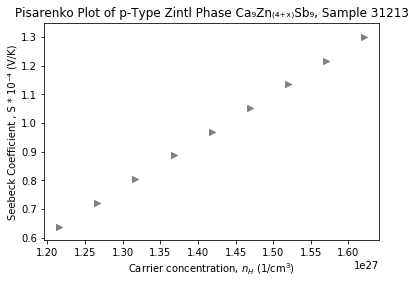

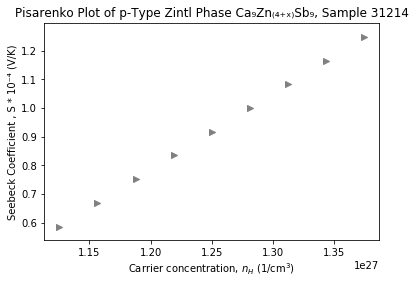

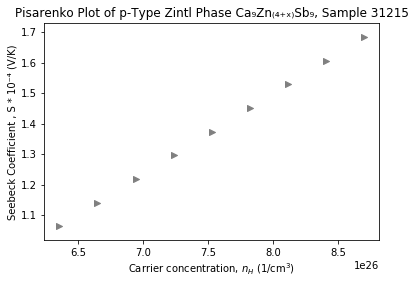

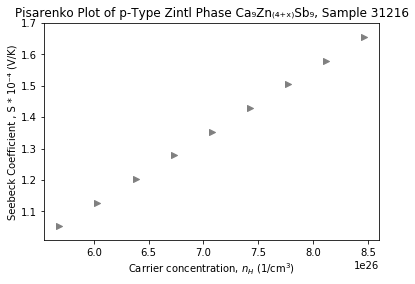

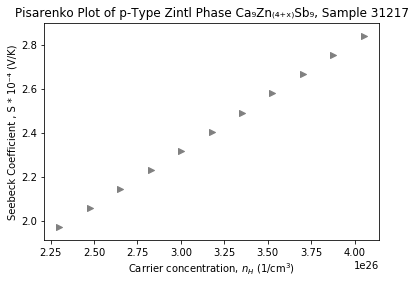

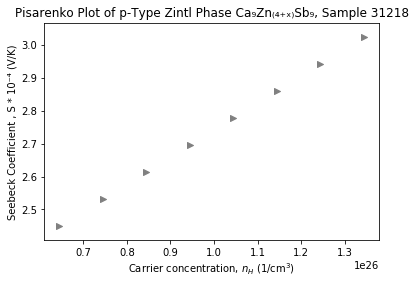

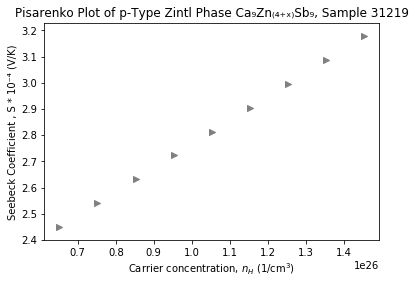

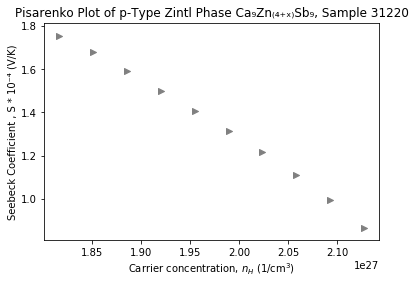

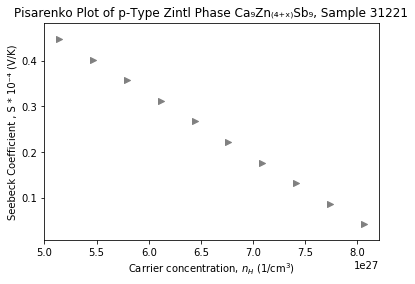

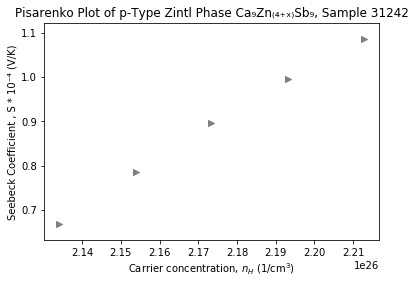

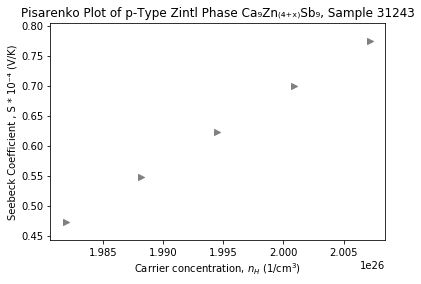

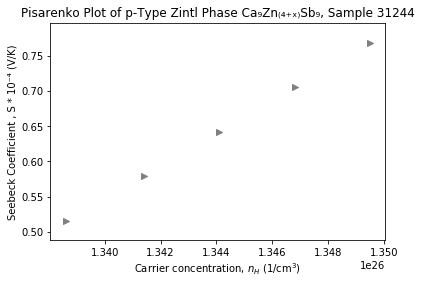

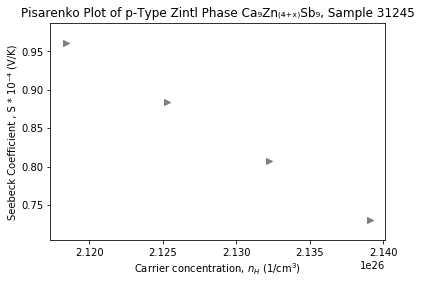

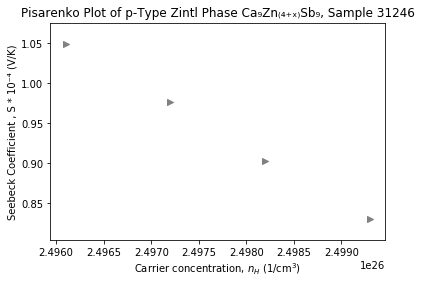

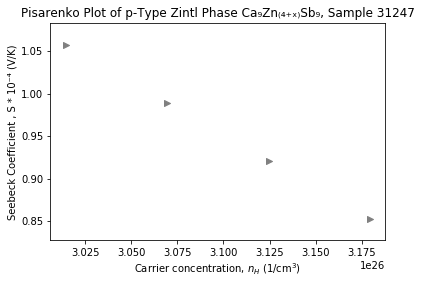

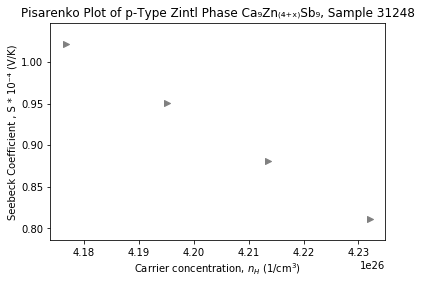

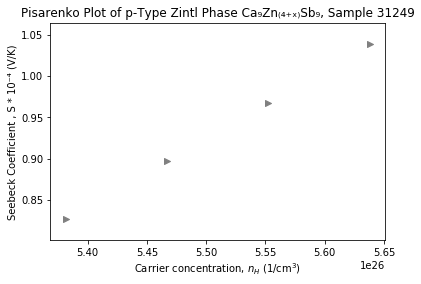

In [26]:
# Pisarenko Plots 
# S dec w/ nH dec cuz metal becomes more metallic 
# carr conc inc w/ T, S dec w/ T 
'''
Added by Ramya: Get list of sample IDs in the new_data
Note: be careful not to name variables "list" because this is
a keyword in Python that shouldn't be overwritten
'''
sid_list = list(new_data.keys()) #To understand this syntax, look up "python dictionaries"
T_list = new_data[sid_list[0]]['Temperature'].to_numpy()
print(T_list)
for i in sid_list: 
    x10 = new_data[i]['Carrier concentration'].to_numpy() #units of V/K
    y10 = new_data[i]['Seebeck coefficient'].to_numpy() * 1e4 #units of Ohm*m
    plt.figure()
    plt.scatter(x10, y10, marker = '>', color = 'grey')
    plt.ylabel('Seebeck Coefficient , S * 10⁻⁴ (V/K)')
    plt.xlabel('Carrier concentration, $n_H$ (1/cm$^3$)')
    plt.title('Pisarenko Plot of p-Type Zintl Phase Ca₉Zn₍₄₊ₓ₎Sb₉, Sample {}'.format(i))
   
# grab interploated data
# Ca Zn Sb compare 
# upwards slope weird - nh inc, S dec ()
# mult S in mV/K, mult by 1e6

/Users/alessandropereyra2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Tellurium


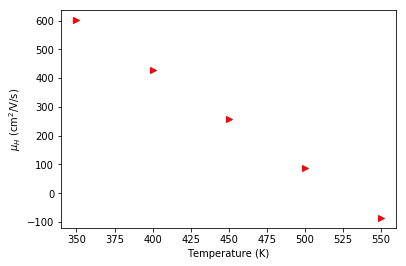

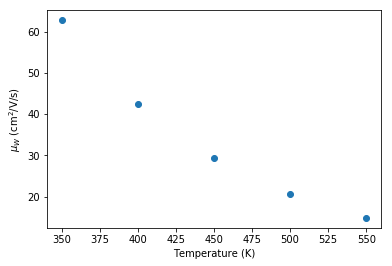

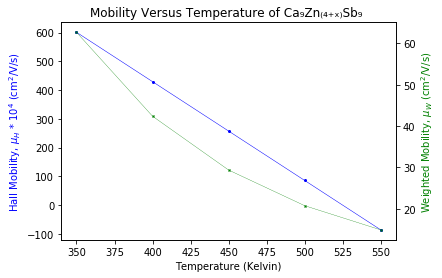

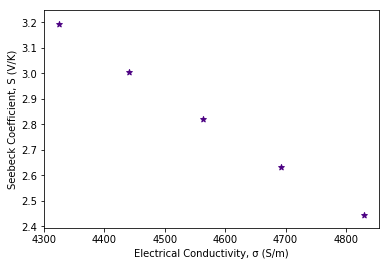

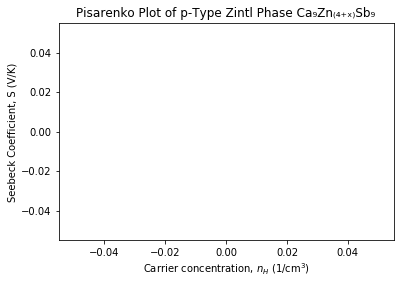

In [35]:
if __name__ == '__main__':
    #Provide path to the .csv file exported from sTarryData2
    full_df = read_STD2('/Users/alessandropereyra2/Desktop/NWREUStuff/litcsvfiles2/Te_ntype](1).csv')
    #Dropping all rows that don't contain mobility data in either "Carrier mobility" or "Hall movility"
    if 'Hall movility' not in full_df.columns:
        full_df['Hall movility'] = np.nan #ad column of empty values
    elif 'Carrier mobility' not in full_df.columns:
        full_df['Carrier mobility'] = np.nan #ad column of empty values
    if 'Carrier concentration' not in full_df.columns:
        full_df['Carrier concentration'] = np.nan #ad column of empty values
    hall_df = full_df.dropna(how = 'all', subset = ['Hall movility','Carrier mobility', 'Carrier concentration'])
    #Drop any rows that don't contain both Seebeck and Conductivity data too
    hall_df = hall_df.dropna(how = 'any', subset = ['Seebeck coefficient', 'Electrical resistivity'])
    #Merge Hall mobility data from different columns
    hall_df = merge_Hallmobility_columns(hall_df)
    hall_df = convert_hall_data(hall_df)
    composition = hall_df['composition'][hall_df.index[0]] #Choosing first composition with Hall mobility data
    #Print composition
    print(composition)
    #Get dataframe for just the composition of interest
    comp_df = reduced_df_by_sample(hall_df, composition)
    #Add weighted mobility data
    comp_df = add_weighted_mobility(comp_df)
    #Plots of weighted mobility and Hall mobility
    plot_mobility(comp_df)
    # call effective mass, in terms of mass by e- (divide)
    comp_df = add_effective_mass(comp_df)
    mean = comp_df['Seebeck Effective Mass'].mean()
    #print(mean)
    stdev = comp_df['Seebeck Effective Mass'].std()
    #print(stdev)
    #print(comp_df['Seebeck Effective Mass'])
    new_data = split_sampleid(comp_df)

['31213', '31214', '31215', '31216', '31217', '31218', '31219', '31220', '31221', '31242', '31243', '31244', '31245', '31246', '31247', '31248', '31249']


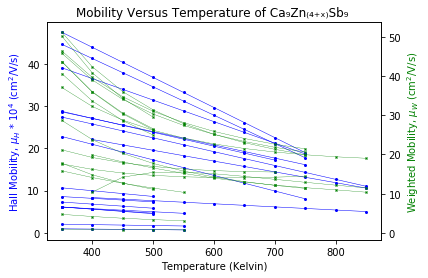

In [28]:
#old
# Weighted Mobility Plots (double axes)

#colors 

items = list(new_data.keys())
print(items)
darkcol = ['firebrick', 'orange', 'green', 'navy', 'purple' ]
lightcol = ['red', 'yellow', 'lime', 'cyan', 'magenta']
fig, ax4 = plt.subplots()
ax5 = ax4.twinx()

for i in items: 
    x = new_data[i]['Temperature'].to_numpy()
    a = new_data[i]['Carrier mobility'].to_numpy() *1e4
    b = new_data[i]['Weighted mobility'].to_numpy() 

    ax4.plot(x, a, 'blue', marker = 'o', linewidth=0.5, markersize=2)
    ax5.plot(x, b, 'green', marker = 'x', linewidth = 0.3, markersize=2)

    ax4.set_xlabel('Temperature (Kelvin)')
    ax4.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'blue')
    ax5.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'green')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
plt.show()
    
# hall are warm colors
# weighted are cold 
# send plots for comments
# check trends, read paper (linearity)

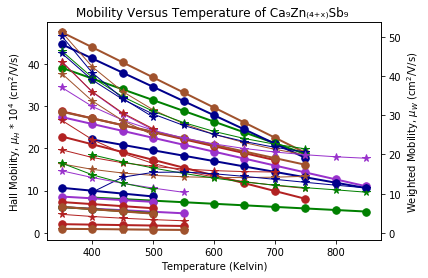

In [29]:
# Weighted Mobility Plots (double axes)

#colors 
items = list(new_data.keys())
darkcol = ['firebrick', 'sienna', 'green', 'darkblue', 'darkorchid' ]
lightcol = ['salmon', 'tan', 'greenyellow', 'lightskyblue', 'thistle']
fig, ax4 = plt.subplots()
ax5 = ax4.twinx()

for i in range(len(items)): #range() function is quite useful for looping through the indices of a list
    x = new_data[items[i]]['Temperature'].to_numpy()
    a = new_data[items[i]]['Carrier mobility'].to_numpy() *1e4
    b = new_data[items[i]]['Weighted mobility'].to_numpy() 
    ax4.plot(x, a, darkcol[i % len(darkcol)], marker = 'o', linewidth = 2, markersize = 7.5) #May repeat colors
    ax5.plot(x, b, darkcol[i % len(darkcol)], marker = '*', linewidth = 1, markersize = 7.5)

    ax4.set_xlabel('Temperature (Kelvin)')
    ax4.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'black')
    ax5.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'black')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
plt.show()
    
# hall are warm colors
# weighted are cold 
# send plots for comments
# check trends, read paper (linearity)
# hall linear
#weighted curved 

In [30]:
#Revised Pisarenko Plots

#List of temperatures where there is data
T_array = new_data[sid_list[0]]['Temperature'].to_numpy()
index_list = list(new_data[sid_list[0]]['Temperature'].index)
print(T_array)
print(index_list)
'''
Create new dictionary with this structure:

'T' : {'n': [list of carrier concentrations], 'S': [list of Seebeck values]}
'''
prenko_dict = {}

for T in T_array:
    n = [] #carrier concentration
    S = [] #Seebeck coefficient
    Smass = [] #Seebeck effective mass
    for k in new_data.keys(): #This is looping through all the sampleIDs in new_data
        indx_list = new_data[k].index
        indx = indx_list[new_data[k]['Temperature'] == T]
        try:
            n.append(float(new_data[k]['Carrier concentration'][indx]))
            S.append(float(new_data[k]['Seebeck coefficient'][indx]))
            Smass.append(float(new_data[k]['Seebeck Effective Mass'][indx]))
        except:
            continue
    prenko_dict[str(T)] = {}
    prenko_dict[str(T)]['Carrier concentration'] = n
    prenko_dict[str(T)]['Seebeck coefficient'] = S
    prenko_dict[str(T)]['Seebeck Effective Mass'] = Smass

[350 400 450 500 550 600 650 700 750]
[0, 1, 2, 3, 4, 5, 6, 7, 8]


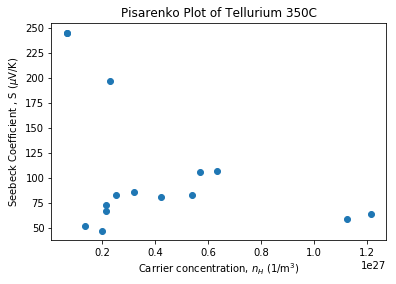

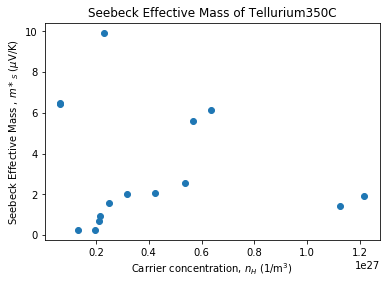

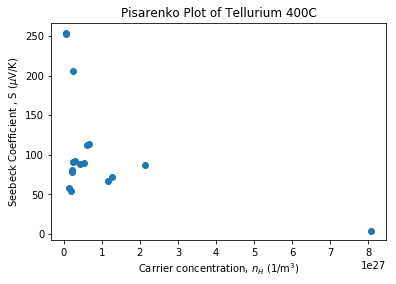

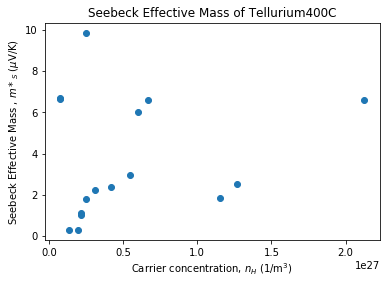

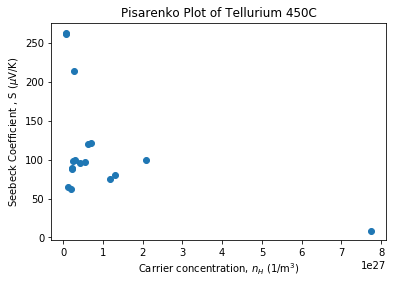

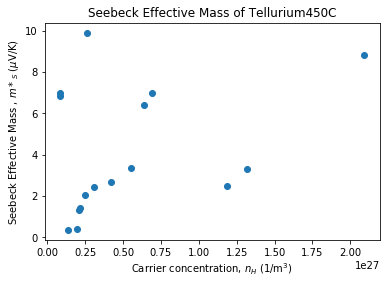

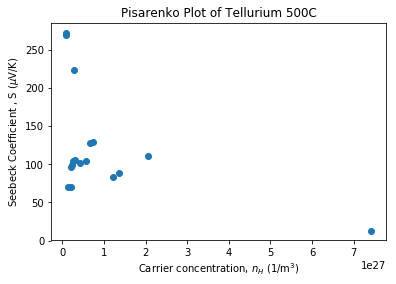

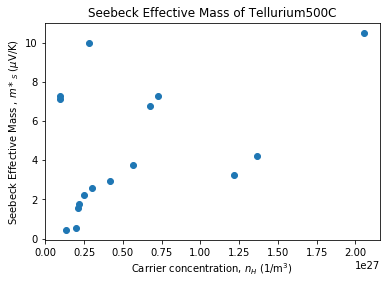

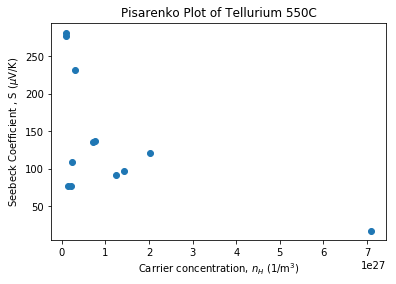

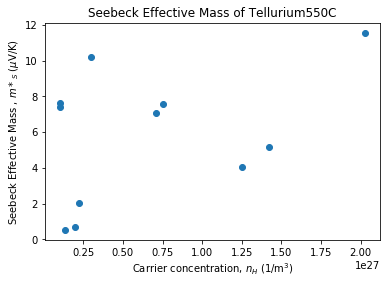

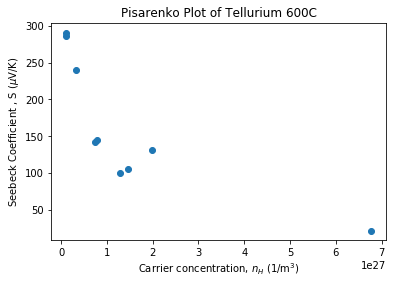

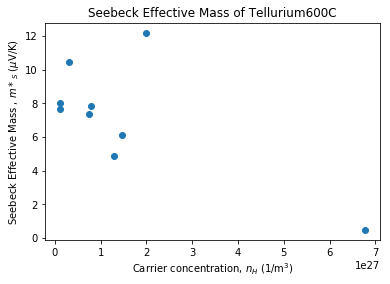

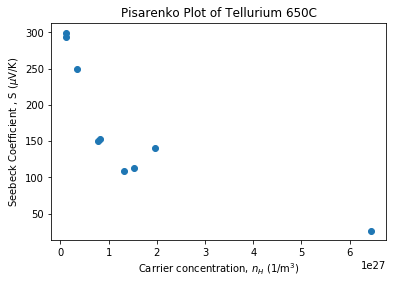

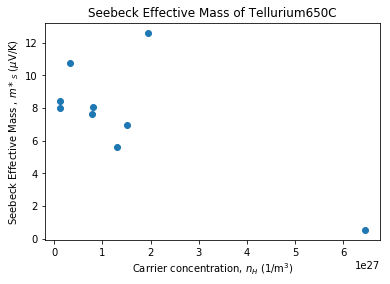

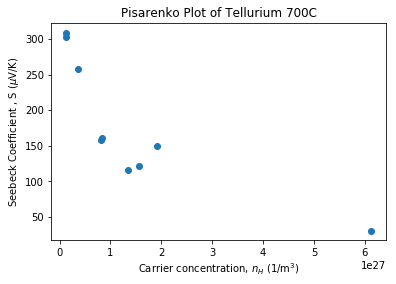

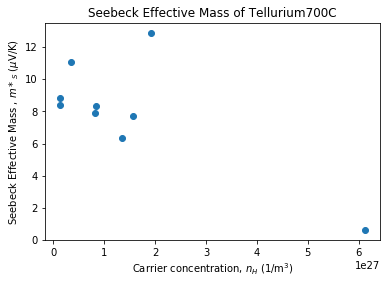

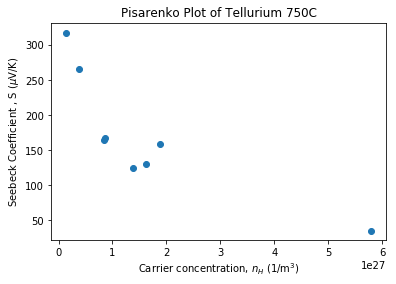

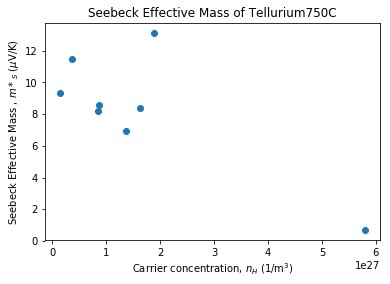

In [38]:
# Plot Updated Pisarenkos

for k in prenko_dict.keys():
    plt.ylabel(r'Seebeck Coefficient , S ($\mu$V/K)')
    plt.xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
    plt.title('Pisarenko Plot of ' + composition + ' ' + k + 'C') #update composition; do proper string formatting
    #Plots of Seebeck versus carrier concentration for each temperature
    plt.scatter(prenko_dict[k]['Carrier concentration'], np.array(prenko_dict[k]['Seebeck coefficient']) * 1e6)
    plt.show()
    #Plots of Seebeck eff. mass versus carrier concentration for each temperature
    plt.ylabel(r'Seebeck Effective Mass , $m*_S$ ($\mu$V/K)')
    plt.xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
    plt.title('Seebeck Effective Mass of ' + composition + k + 'C')     
    plt.scatter(prenko_dict[k]['Carrier concentration'], prenko_dict[k]['Seebeck Effective Mass'])    
    plt.show()

In [32]:
# effective mass calcs
x = np.arange(31213, 31222)
i = 0
arr = []
arr1 = np.array([])
z = 0
arr2 = np.array([])
arr3 = np.array([])

# while loop to get 3 separate arrays 
while i < len(x):
    # temperature array
    out1a = out1
    out1 = new_data[str(x[i])]['Temperature'].to_numpy()
    arr1 = np.append(arr1,out1)
    arr1 = np.append(arr1,out1a)
    # carrier conc array
    out2a = out2
    out2 = new_data[str(x[i])]['Carrier concentration'].to_numpy()
    arr2 = np.append(arr2,out2)
    arr2 = np.append(arr2,out2a)
    # S coeff array
    out3a = out3
    out3 = new_data[str(x[i])]['Seebeck Effective Mass'].to_numpy()
    arr3 = np.append(arr3,out3)
    arr3 = np.append(arr3,out3a)
    i = i + 1



NameError: name 'out1' is not defined

In [ ]:
#z = new_data['31213']['Seebeck Effective Mass'].to_numpy() #units of V/K
#print(z)

# Effective Mass Plots

#colors 
nums = [ 1, 2, 3, 4, 5] 
items = list(new_data.keys())
darkcol = ['firebrick', 'sienna', 'green', 'darkblue', 'darkorchid' ]
lightcol = ['salmon', 'tan', 'greenyellow', 'lightskyblue', 'thistle']
fig, ax4 = plt.subplots()
ax5 = ax4.twinx()

for i in range(len(items)): 
    x = new_data[items[i]]['Temperature'].to_numpy()
    a = new_data[items[i]]['Carrier mobility'].to_numpy() *1e4
    b = new_data[items[i]]['Weighted mobility'].to_numpy() 

    ax4.plot(x, a, darkcol[i], marker = 'o', linewidth = 2, markersize = 7.5)
    ax5.plot(x, b, darkcol[i], marker = '*', linewidth = 1, markersize = 7.5)

    ax4.set_xlabel('Temperature (Kelvin)')
    ax4.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'black')
    ax5.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'black')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
plt.show()
    
# hall are warm colors
# weighted are cold 
# send plots for comments
# check trends, read paper (linearity)
# hall linear
# weighted curved 

In [ ]:
nums = [ 1, 2, 3, 4, 5] 
for i in nums: 
    
    items = ['31213', '31214', '31215', '31216', '31217']
    darkcol = ['firebrick', 'sienna', 'green', 'darkblue', 'darkorchid' ]
    lightcol = ['salmon', 'tan', 'greenyellow', 'lightskyblue', 'thistle']
    fig, ax4 = plt.subplots()
    ax5 = ax4.twinx()


    x = arr350x[i]
    a = arr350y[i]
    b = arr350ye[i] 

    ax4.plot(x, a, darkcol[i-5], marker = 'o', linewidth = 2, markersize = 7.5)
    ax5.plot(x, b, darkcol[i-5], marker = '*', linewidth = 1, markersize = 7.5)

    ax4.set_xlabel('Temperature (Kelvin)')
    ax4.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'black')
    ax5.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'black')
    plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
plt.show()
    
# fitted effective mass plot 350 

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()



ax1.plot(arr350x, arr350y, 'blue', marker = 'o', linewidth=0.5, markersize=2)
ax2.plot(arr350x, arr350ye[:len(arr350x)], 'green', marker = 'x', linewidth = 0.3, markersize=2)

ax1.set_xlabel('Carrier concentration, $n_H$ (1/m$^3$)')
ax1.set_ylabel('Hall Mobility, $\mu_H$ * 10$^4$ (cm$^2$/V/s)', color = 'blue')
ax2.set_ylabel('Weighted Mobility, $\mu_W$ (cm$^2$/V/s) ', color = 'green')
plt.title('Mobility Versus Temperature of Ca₉Zn₍₄₊ₓ₎Sb₉ ')
plt.show()
       